In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
import corner

In [8]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw = Table.read('../spectrum_post_processing/galah_dr4_allstar_not_validated.fits')
galah_dr4_raw['source_id'] = galah_dr4_raw['gaiadr3_source_id']

In [9]:
# Then read in GALAH DR3
seismic_k2 = Table.read('../auxiliary_information/Zinn2021_asteroseismic_values/K2_GaiaDR2_crossmatch.fits')
seismic_k2['numax'] = seismic_k2['numax_mean']
seismic_k2['e_numax'] = seismic_k2['numax_scatter']
seismic_tess = Table.read('../auxiliary_information/Hon2021_asteroseismic_values/apjac14b1t1_220902.fits')

In [10]:
seismic_k2_galahdr4 = join(galah_dr4_raw,seismic_k2,keys='source_id')
seismic_k2_galahdr4['k2_tic'] = np.array(['k2' for x in range(len(seismic_k2_galahdr4['sobject_id']))])
seismic_tess_galahdr4 = join(galah_dr4_raw,seismic_tess,keys='tmass_id')
seismic_tess_galahdr4['k2_tic'] = np.array(['tess' for x in range(len(seismic_tess_galahdr4['sobject_id_1']))])

In [36]:
seismic_k2_galahdr4_so = seismic_k2_galahdr4['sobject_id']
seismic_k2_galahdr4_so[7800]

190209004201219

In [46]:
joined = vstack([seismic_k2_galahdr4,seismic_tess_galahdr4])

In [47]:
nu_max_model = (10**joined['logg']) / (10**4.438) * np.sqrt(joined['teff'] / 5772.) * 3090.

logg_seis = np.log10(joined['numax'] / 3090. * (10**4.438) * np.sqrt(joined['teff'] / 5772.))

In [48]:
use = np.isfinite(joined['teff']) & np.isfinite(joined['logg']) & np.isfinite(logg_seis)
joined = joined[use]
nu_max_model = nu_max_model[use]
logg_seis = logg_seis[use]

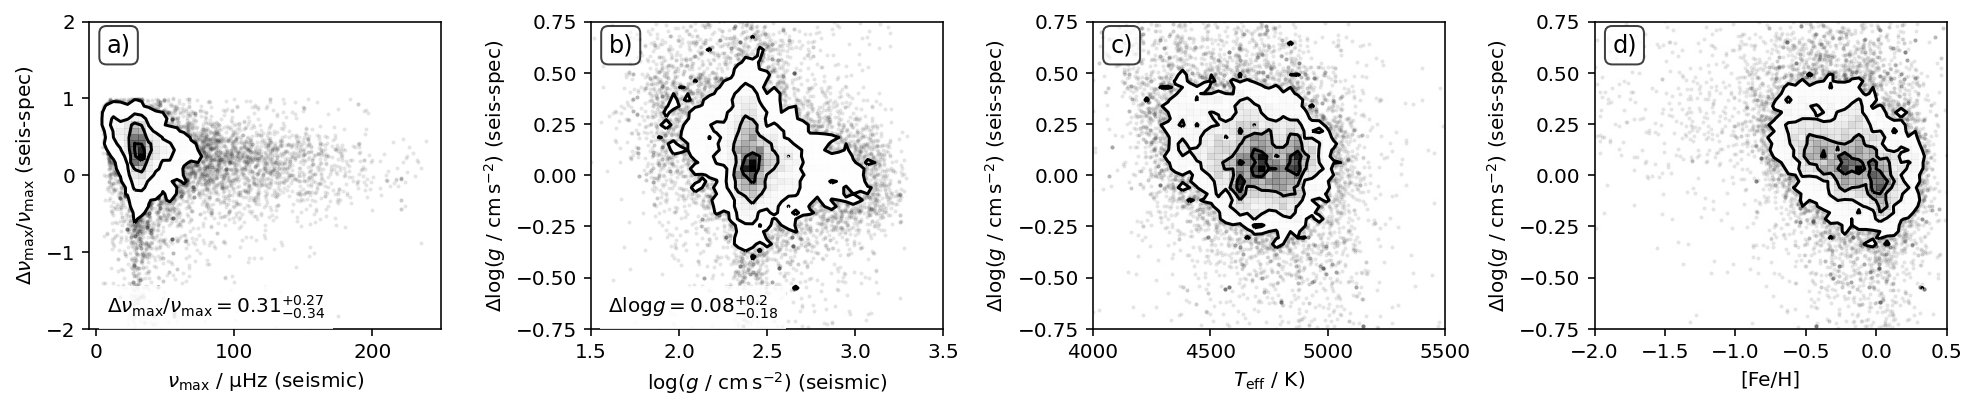

In [49]:
f, gs = plt.subplots(1,4,figsize=(14,3))

ax = gs[0]
ax.text(0.05,0.9,'a)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
corner.hist2d(
    joined['numax'],
    (joined['numax'] - nu_max_model)/joined['numax'],
    ax=ax,
    bins=(np.linspace(0,250,50),np.linspace(-2,2,50)),
    range = [(-5,250),(-2,2)]
)
percentiles = np.percentile((joined['numax'] - nu_max_model)/joined['numax'],q=[16,50,84])
text = r'$\Delta\nu_\mathrm{max}/\nu_\mathrm{max} = {'+str(np.round(percentiles[1],decimals=2))+'}_{-'+str(np.round(percentiles[1]-percentiles[0],decimals=2))+'}^{+'+str(np.round(percentiles[2]-percentiles[1],decimals=2))+'}$'
ax.text(0.05,0.05,text,transform=ax.transAxes,bbox=dict(lw=0, facecolor='w', alpha=0.85))
ax.set_xlabel(r'$\nu_\mathrm{max}~/~\mathrm{\mu}\mathrm{Hz}$ (seismic)')
ax.set_ylabel(r'$\Delta\nu_\mathrm{max}/\nu_\mathrm{max}$ (seis-spec)')

ax = gs[1]
ax.text(0.05,0.9,'b)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
corner.hist2d(
    logg_seis,
    (logg_seis - joined['logg']),
    ax=ax,
    bins=(np.linspace(1.5,3.5,50),np.linspace(-0.75,0.75,50)),
    range = [(1.5,3.5),(-0.75,0.75)]
)
percentiles = np.percentile(logg_seis - joined['logg'],q=[16,50,84])
text = r'$\Delta \log g = {'+str(np.round(percentiles[1],decimals=2))+'}_{-'+str(np.round(percentiles[1]-percentiles[0],decimals=2))+'}^{+'+str(np.round(percentiles[2]-percentiles[1],decimals=2))+'}$'
ax.text(0.05,0.05,text,transform=ax.transAxes,bbox=dict(lw=0, facecolor='w', alpha=0.85))

ax.set_xlabel(r'$\log (g~/~\mathrm{cm\,s^{-2}})$ (seismic)')
ax.set_ylabel(r'$\Delta\log (g~/~\mathrm{cm\,s^{-2}})$ (seis-spec)')

ax = gs[2]
ax.text(0.05,0.9,'c)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
corner.hist2d(
    joined['teff'],
    (logg_seis - joined['logg']),
    ax=ax,
    bins=(np.linspace(4000,5500,50),np.linspace(-0.75,0.75,50)),
    range = [(4000,5500),(-0.75,0.75)]
)
ax.set_xlabel(r'$T_\mathrm{eff}~/~\mathrm{K})$')
ax.set_ylabel(r'$\Delta\log (g~/~\mathrm{cm\,s^{-2}})$ (seis-spec)')

ax = gs[3]
ax.text(0.05,0.9,'d)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
corner.hist2d(
    joined['fe_h'],
    (logg_seis - joined['logg']),
    ax=ax,
    bins=(50,np.linspace(-0.75,0.75,50)),
    range = [(-2.,0.5),(-0.75,0.75)]
)
ax.set_xlabel(r'[Fe/H]')
ax.set_ylabel(r'$\Delta\log (g~/~\mathrm{cm\,s^{-2}})$ (seis-spec)')
plt.tight_layout()

In [31]:
np.percentile(logg_seis - joined['logg'], q=[16,50,84])

array([nan, nan, nan])